<a href="https://colab.research.google.com/github/sahildalmia/face1/blob/main/support_ticket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-support-ticket-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3349722%2F5828126%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240227T092829Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2361dc9af4e3d27a76a45a3e8090648707f067bcaaf9c8545d066ad7ec824820bd907c712c48e6f02b164c20b0c79ef757df348fd94d8196b76f31f5b903e5d994a30f7abb7b3b129735b595266628e7aa877402d6e0f82e6fdce51f50c91f2e6d7e1da54bdf479cd63046308d9a69dd76368456d7610fbdec2a005aec444bf869c7a3cf6bb3bb334c26d3f2f25bc5df1e7c4273206a4d1a5e90ca86cbc67b8c5184307368ac8e7d515962891079038911c5071bb47b2a1ba84c4b31ef07c387ffc34d7f26cac3bc262bebeeb902d6ecffd0d57bd02f4ca086501031d47ac560fa1a4093535bb5c855c642ab550e7292e7d1f0ff958aeb53951e0bea1dbe70ca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 847457 bytes downloaded
Downloaded and uncompressed: customer-support-ticket-dataset
Data source import complete.


<a id="1"></a>
# <div style="padding:15px;color:blue;margin:0;font-size:35px;font-family:Verdana;text-align:left;display:fill;border-radius:5px;background-color:orange;overflow:hidden"><b>I. Introduction</b></div>

<a id="1.1"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>1. About dataset</b></div>

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">
The Customer Support Ticket Dataset is a dataset that includes support tickets for various tech products. It consists of customer inquiries related to hardware issues, software bugs, network problems, account access, data loss, and other support topics. The dataset provides information about the customer, the product purchased, the ticket type, the ticket channel, the ticket status, and other relevant details.
    
Support ticket is a channel where customers can send the problem they met when using the products to technical staff for a best resolution. And each of case always have a rating point for judging the effective resolution and the satisfaction of customer. Support ticket is one of the most important part in customer care department and can be one of the reason whether customer continue to buy a new product.
    
Therefore, this project select this topic and dataset for the purpose of:
- Analyze customer support ticket trends, identify common issues, and improve support processes.
- Analyze sentiment text in ticket description.

<a id="1.2"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>2. Dataset Structure</b></div>

|STT | Attribute Name | Meaning |
|:--- | :--- |:--- |
| 1 | Ticket ID | A unique identifier for each ticket |
| 2 | Customer Name | The name of the customer who raised the ticket |
| 3 | Customer Email | The email address of the customer (Domain name - @example.com is intentional for user data privacy concern) |
| 4 | Customer Age | The age of the customer |
| 5 | Customer Gender | The gender of the customer |
| 6 | Product Purchased | The tech product purchased by the customer |
| 7 | Date of Purchase | The date when the product was purchased |
| 8 | Ticket Type | The type of ticket (e.g., technical issue, billing inquiry, product inquiry) |
| 9 | Ticket Subject | The subject/topic of the ticket |
| 10 | Ticket Description | The description of the customer's issue or inquiry |
| 11 | Ticket Status | The status of the ticket (e.g., open, closed, pending customer response) |
| 12 | Resolution | The resolution or solution provided for closed tickets |
| 13 | Ticket Priority | The priority level assigned to the ticket (e.g., low, medium, high, critical) |
| 14 | Ticket Channel | The channel through which the ticket was raised (e.g., email, phone, chat, social media) |
| 15 | First Response Time | The time taken to provide the first response to the customer |
| 16 | Time to Resolution | The time taken to resolve the ticket |
| 17 | Customer Satisfaction Rating | The customer's satisfaction rating for closed tickets (on a scale of 1 to 5) |

<a id="1.3"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>3. Import Library</b></div>

In [3]:
import re
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
#import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<a id="2"></a>
# <div style="padding:15px;color:blue;margin:0;font-size:35px;font-family:Verdana;text-align:left;display:fill;border-radius:5px;background-color:orange;overflow:hidden"><b>II. Data Discovery</b></div>

<a id="2.1"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>1. General data information</b></div>

In [4]:
#Reading the data
df = pd.read_csv('/kaggle/input/customer-support-ticket-dataset/customer_support_tickets.csv')
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [5]:
nums_rows, nums_columns = df.shape
print(f'Number of rows: {nums_rows}\nNumber of columns: {nums_columns}')

Number of rows: 8469
Number of columns: 17


In [6]:
#Checking duplicate line
duplicate = df.duplicated().any()
duplicate

False

**💬 Comment:** So there are no duplicate rows in the data.

In [7]:
df.info()
cat_cols  = df.select_dtypes(['object']).columns
int_cols  = df.select_dtypes(['int64']).columns
float_cols = df.select_dtypes(['float']).columns
print(cat_cols)
print(int_cols)
print(float_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

<a id="2.2"></a>
# <div style="color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;background-color:#fffff;overflow:hidden"><b>2. Cleaning data</b></div>

In [8]:
#Convert to datetime
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], format = '%Y-%m-%d')
df['First Response Time'] = pd.to_datetime(df['First Response Time'], format = '%Y-%m-%d %H:%M:%S')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], format = '%Y-%m-%d %H:%M:%S')

In [9]:
df_ticket = df.drop(columns = ['Ticket ID'], axis = 1)

**💬 Comment:** Because the Ticket ID columns is similar to the index of table so I drop it

In [10]:
#Cleaning data
df_ticket['Resolution'] = df_ticket['Resolution'].fillna('None')
df_ticket['First Response Time'] = df_ticket['First Response Time'].fillna('No response')
df_ticket['Time to Resolution'] = df_ticket['Time to Resolution'].fillna('No resolution')
df_ticket['Customer Satisfaction Rating'] = df_ticket['Customer Satisfaction Rating'].fillna('No rating')

**💬 Comment:** Now just checking again the data after cleaning

In [73]:
df_ticket.isnull().sum()

Customer Name                   0
Customer Email                  0
Customer Age                    0
Customer Gender                 0
Product Purchased               0
Date of Purchase                0
Ticket Type                     0
Ticket Subject                  0
Ticket Description              0
Ticket Status                   0
Resolution                      0
Ticket Priority                 0
Ticket Channel                  0
First Response Time             0
Time to Resolution              0
Customer Satisfaction Rating    0
Type of Customer                0
Response                        0
Resolution_bin                  0
dtype: int64

<a id="2.3"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>3. Discover some distribution</b></div>

<a id="2.3.1"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>a. Distribution of customer age</b></div>

In [11]:
print(df_ticket['Customer Age'].max())
print(df_ticket['Customer Age'].min())

70
18


**💬 Comment:**
- The range of customer age from 18 to 70 years old.
- I will class them into 3 kinds of customer: Young, Middle Age and Old.

In [12]:
age = []
for i in df_ticket['Customer Age']:
    if i<=30:
        age.append('Young Customer')
    elif 30<i<55:
        age.append('Middle Age Customer')
    else:
        age.append('Old Customer')
df_ticket['Type of Customer'] = age

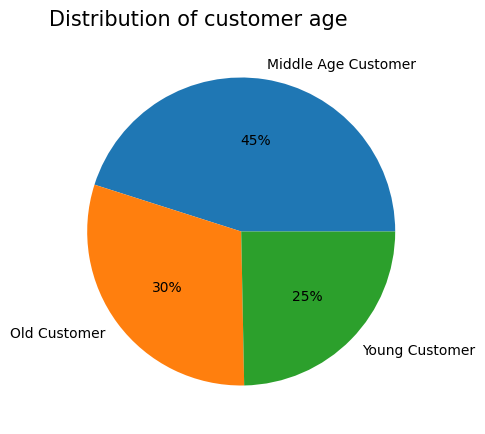

In [13]:
chart_age = df_ticket['Type of Customer'].value_counts()
chart_gen = df_ticket['Customer Gender'].value_counts()
plt.figure(figsize = (10,5))
plt.pie(chart_age, labels = chart_age.index, autopct='%.0f%%')
plt.title('Distribution of customer age', loc = 'left', pad = 10, size = 15)
plt.show()

**💬 Comment:** Most of customer age is more than 30 and the middle age customer is the main target buying most produce.

<a id="2.3.2"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>b. Distribution of customer gender</b></div>

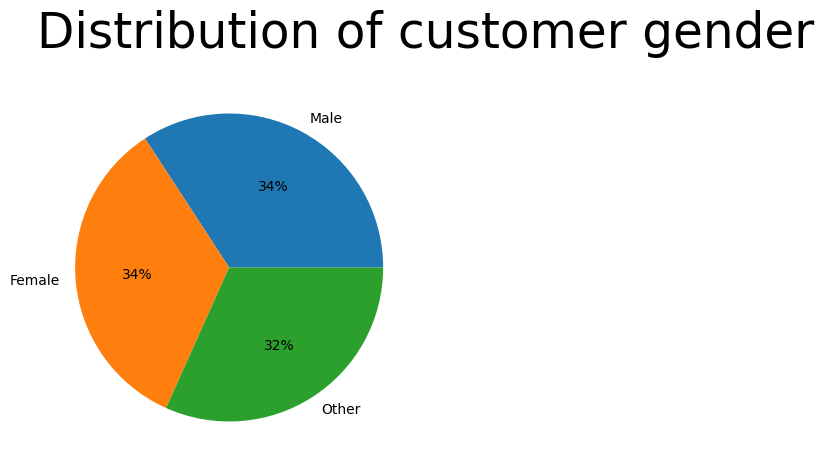

In [75]:
chart_gen = df_ticket['Customer Gender'].value_counts()
plt.figure(figsize = (10,5))
plt.pie(chart_gen, labels = chart_gen.index, autopct='%.0f%%')
plt.title('Distribution of customer gender', loc = 'left', pad = 20, size = 35)
plt.show()

**💬 Comment:** Customer in this dataset reach a balance value in distribution of gender.

<a id="2.3.3"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>c. Distribution of product</b></div>

In [15]:
unique = len(df_ticket['Product Purchased'].unique())
print(f' Total of products was purchased: {unique}')

 Total of products was purchased: 42


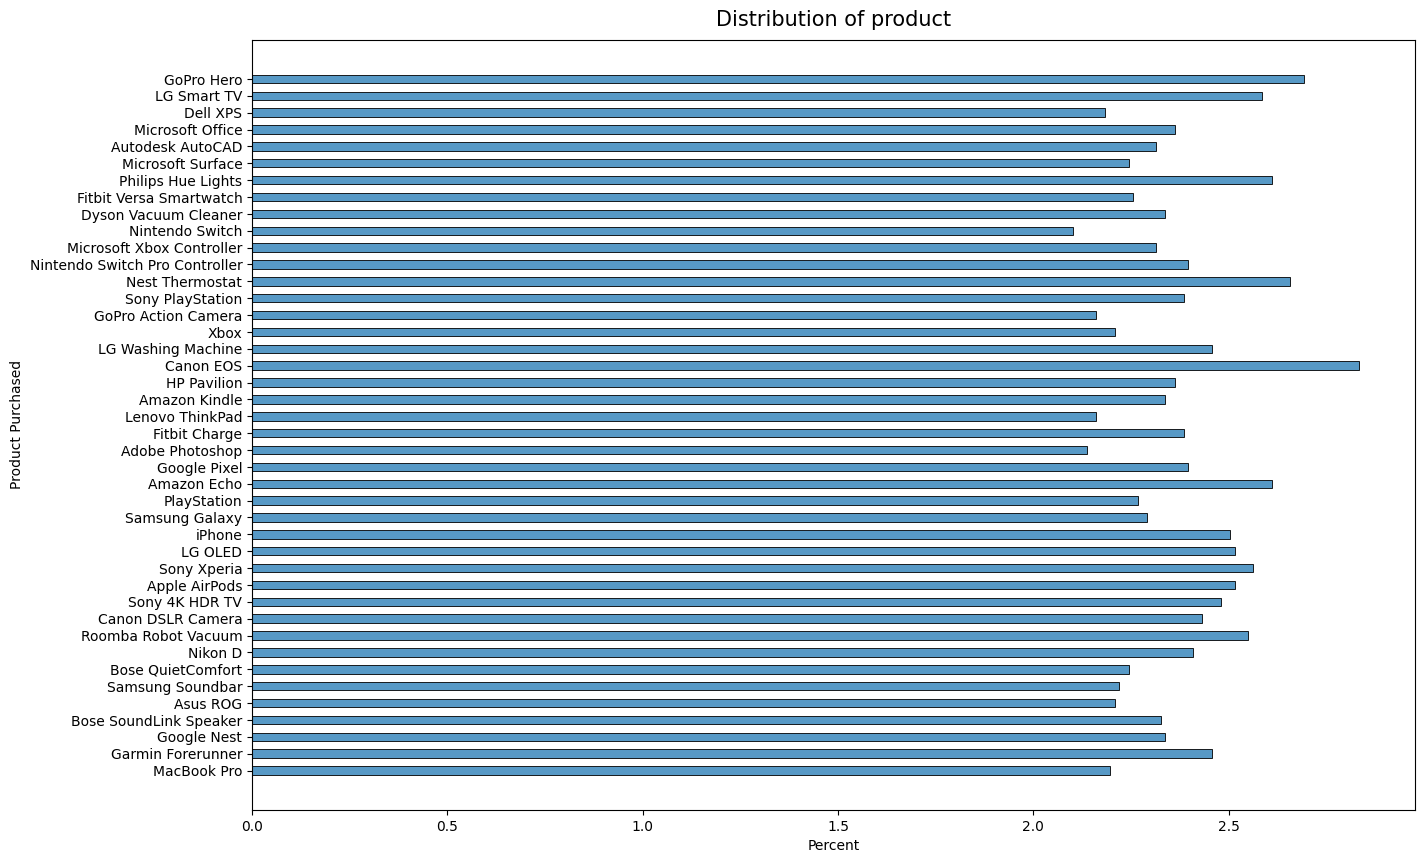

In [78]:
#Plot chart
plt.figure(figsize = (15,10))
sns.histplot(data = df_ticket, y = 'Product Purchased', stat = 'percent', shrink = 0.5)
plt.title('Distribution of product', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:**: Go Pro Hero, Cannon EOS and Nest Thermostat are the top three products have the most pruchased.

<a id="2.3.4"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>d. Distribution of ticket channel</b></div>

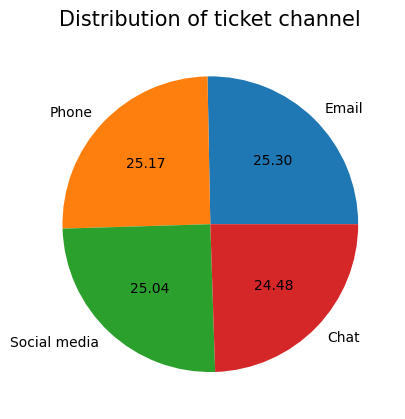

In [17]:
chart_chan = df_ticket['Ticket Channel'].value_counts()
plt.pie(chart_chan, labels = chart_chan.index, autopct = '%.2f')
plt.title('Distribution of ticket channel', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** This company has 4 channel for customer to find the technical staff and the usage level of each channel don't have too much different.

<a id="2.3.5"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>d. Distribution of ticket priority</b></div>

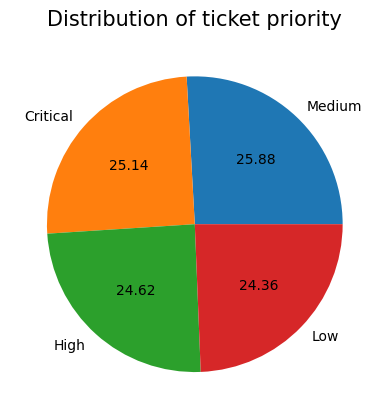

In [18]:
chart_prio = df_ticket['Ticket Priority'].value_counts()
plt.pie(chart_prio, labels = chart_prio.index, autopct = '%.2f')
plt.title('Distribution of ticket priority', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** Just like the ticket channel, the cases are ranked into four priority level of ticket and the number of cases in each level are quite similar.

<a id="2.3.6"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>e. Chance of response</b></div>

In [19]:
chance = []
for i in df_ticket['First Response Time']:
    if i == 'No response':
        chance.append('No')
    else:
        chance.append('Yes')
df_ticket['Response'] = chance

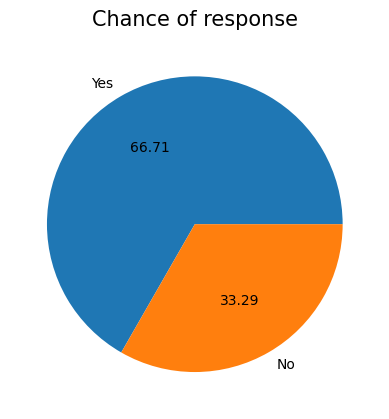

In [20]:
chart_res = df_ticket['Response'].value_counts()
plt.pie(chart_res, labels = chart_res.index, autopct = '%.2f')
plt.title('Chance of response', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** 66.71% ticket sent was responsed by the technical staff.

<a id="2.3.7"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>f. Chance of resolution</b></div>

In [21]:
chance_r = []
for i in df_ticket['Time to Resolution']:
    if i == 'No resolution':
        chance_r.append('No')
    else:
        chance_r.append('Yes')
df_ticket['Resolution_bin'] = chance_r

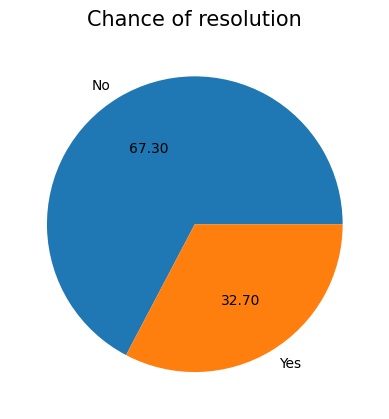

In [22]:
chart_re = df_ticket['Resolution_bin'].value_counts()
plt.pie(chart_re, labels = chart_re.index, autopct = '%.2f')
plt.title('Chance of resolution', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** 32,70% cases sent was resolved by the technical staff.

<a id="2.3.7"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>g. Distribution of customer satisfaction rating</b></div>

**💬 Comment:** In the data structure part, customer satisfaction rating are scored from 1 to 5 and the higher rating satisfaction score, the better in quality service of Support ticket department.

In [23]:
#Convert 'Customer Satisfaction Rating' columns into object type
df_ticket['Customer Satisfaction Rating'] = df_ticket['Customer Satisfaction Rating'].astype('object')
df_ticket['Customer Satisfaction Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8469 entries, 0 to 8468
Series name: Customer Satisfaction Rating
Non-Null Count  Dtype 
--------------  ----- 
8469 non-null   object
dtypes: object(1)
memory usage: 66.3+ KB


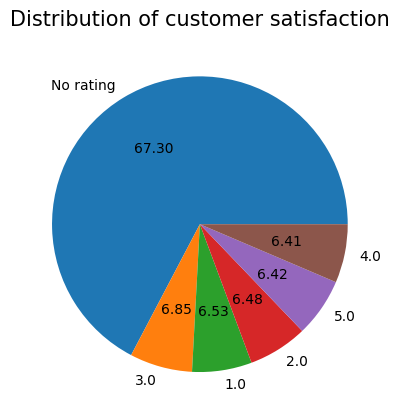

In [24]:
chart_satis = df_ticket['Customer Satisfaction Rating'].value_counts()
plt.pie(chart_satis, labels = chart_satis.index, autopct = '%.2f')
plt.title('Distribution of customer satisfaction', loc = 'center', pad = 10, size = 15)
plt.show()

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">

  **Conclusion:**
- The company has IT products for the main customer above 30 years old and usable for all gender.
- There is a balance in amount of case was sent to ticket channel and ranked by priority ticket level.
- However, only 32.70% case sent was resolved.
- All rating had the same rate in number of cases rated so the ticket support department in this company just worked moderately and need to change for increasing the customer satisfaction.

<a id="2.4"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>4. Discover some relationships</b></div>

<a id="2.4.1"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>a. Ticket channel and ticket priority</b></div>

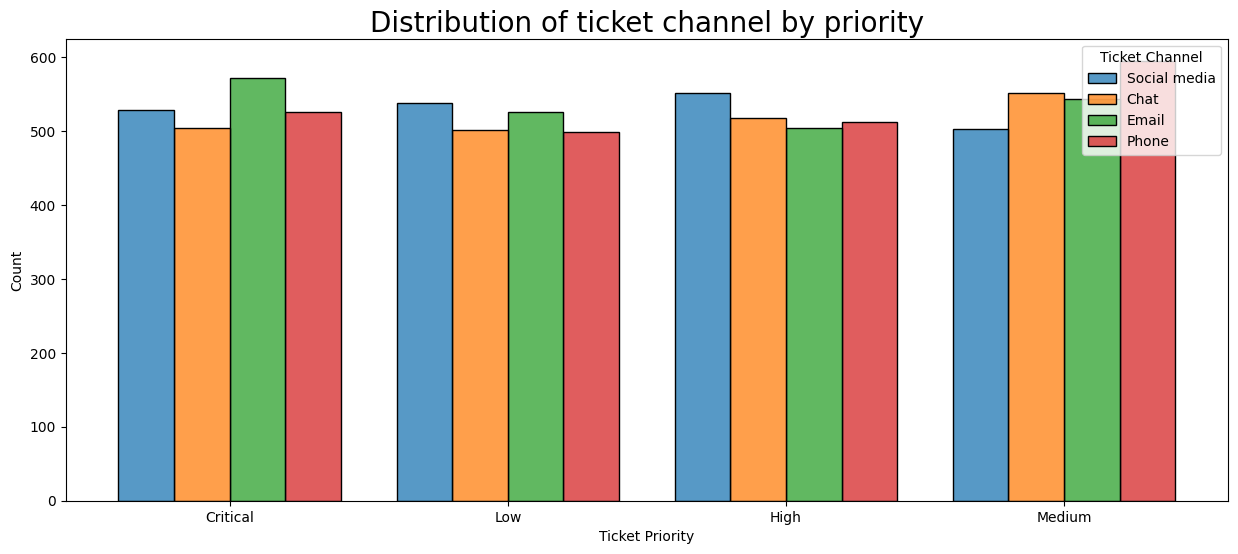

In [79]:
plt.figure(figsize = (15,6))
sns.histplot(df_ticket, hue = 'Ticket Channel', x = 'Ticket Priority',multiple = 'dodge', shrink = 0.8)
plt.title('Distribution of ticket channel by priority', loc = 'center', pad = 5, size = 20)
plt.show()

**💬 Comment:** Although each ticket channel has similar in number of cases was sent, but:
- Email is the channel has the most cases was ranked critical level
- Social media is the channel customers

<a id="2.4.2"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>b. Ticket status</b></div>

In [26]:
ticket_st = df_ticket['Ticket Status'].unique()
print(f'Ticket status: {list(ticket_st)}')

Ticket status: ['Pending Customer Response', 'Closed', 'Open']


**💬 Comment:**
- In this dataset, there are three status of tickets when a problem was sent: open, closed and pending response.
- The chart below show that 100% ticket in closed and pending response status was responsed.
- However, only **closed ticket** was resolved with the rate 100%.

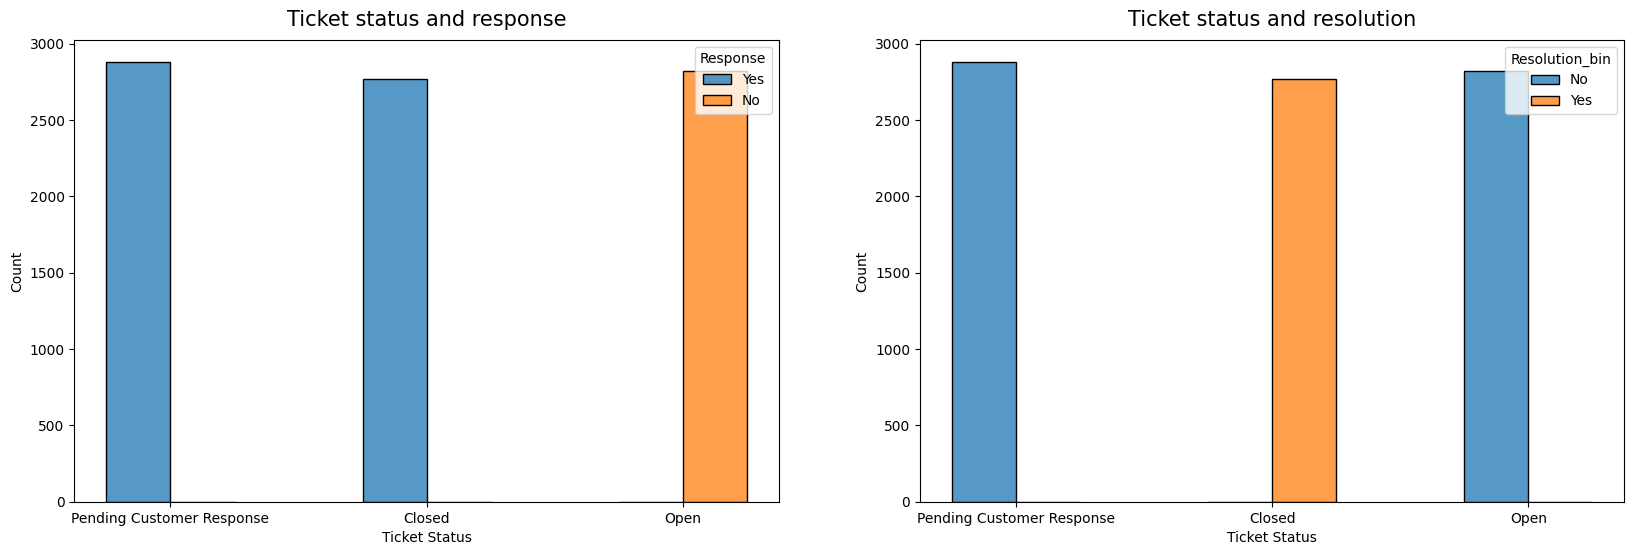

In [27]:
fig, axes = plt.subplots(1,2, figsize = (20,6))
sns.histplot(df_ticket, x = 'Ticket Status', hue = 'Response',multiple = 'dodge', shrink = 0.5, ax = axes[0])
sns.histplot(df_ticket, x = 'Ticket Status', hue = 'Resolution_bin',multiple = 'dodge', shrink = 0.5, ax = axes[1])
axes[0].set_title('Ticket status and response',loc = 'center', pad = 10, size = 15)
axes[1].set_title('Ticket status and resolution',loc = 'center', pad = 10, size = 15)
plt.show()

<a id="2.4.3"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>c. Ticket priority and solution</b></div>

In [80]:
#Create a pivot table for caculating
priority = pd.pivot_table(df_ticket, index = ['Ticket Priority'], values = ['Customer Name'], columns = ['Resolution_bin'], aggfunc = len).reset_index()
priority = priority.rename(columns = {'Customer Name': 'Chance of Solution'})
priority['Percent'] = (priority['Chance of Solution']['Yes']/priority['Chance of Solution']['No'])*100
priority

Ticket Priority Chance of Solution         Percent
Resolution_bin                                 No  Yes           
0                     Critical               1403  726  51.746258
1                         High               1380  705  51.086957
2                          Low               1419  644  45.384073
3                       Medium               1498  694  46.328438

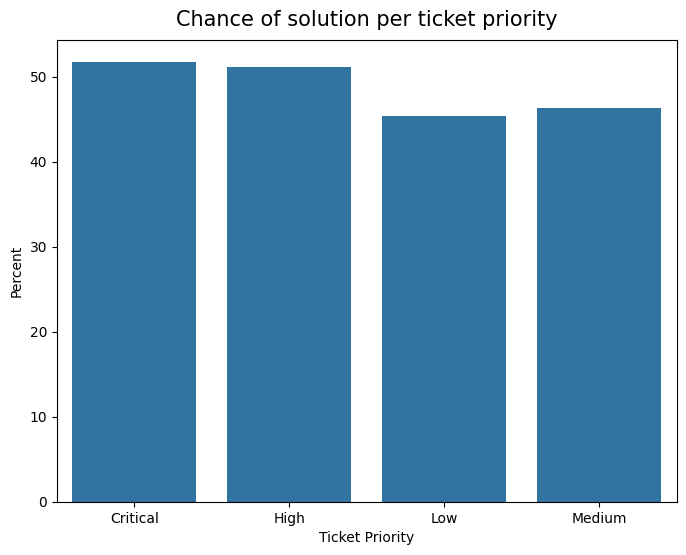

In [30]:
plt.figure(figsize = (8,6))
sns.barplot(priority, x = 'Ticket Priority', y = 'Percent')
plt.title('Chance of solution per ticket priority', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** High and Critical priority ticket only have a slightly higher in chance of solution than low and medium.

<a id="2.4.3"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>c. Customer satisfaction rating</b></div>

In [31]:
rating = pd.pivot_table(df_ticket, index = ['Customer Satisfaction Rating'], values= ['Customer Name'], columns = ['Resolution_bin'], aggfunc = len).reset_index()
rating = rating.rename(columns = {'Customer Name': 'Resolution'})
rating

Customer Satisfaction Rating Resolution       
Resolution_bin                                      No    Yes
0                                       1.0        NaN  553.0
1                                       2.0        NaN  549.0
2                                       3.0        NaN  580.0
3                                       4.0        NaN  543.0
4                                       5.0        NaN  544.0
5                                 No rating     5700.0    NaN

**💬 Comment:** Because all rating from customers were in resolution problems, so I will create a new dataframe contains all data of resolution cases for a deeper look in rating.

In [32]:
#Create new dataframe
df_resolution = df_ticket[df_ticket['Resolution_bin'] =='Yes']
df_resolution.head()

,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Type of Customer,Response,Resolution_bin
2,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,Middle Age Customer,Yes,Yes
3,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,Young Customer,Yes,Yes
4,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,Old Customer,Yes,Yes
10,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,2023-06-01 17:46:49,2023-05-31 23:51:49,1.0,Middle Age Customer,Yes,Yes
11,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,2023-06-01 12:05:51,2023-06-01 09:27:51,1.0,Middle Age Customer,Yes,Yes


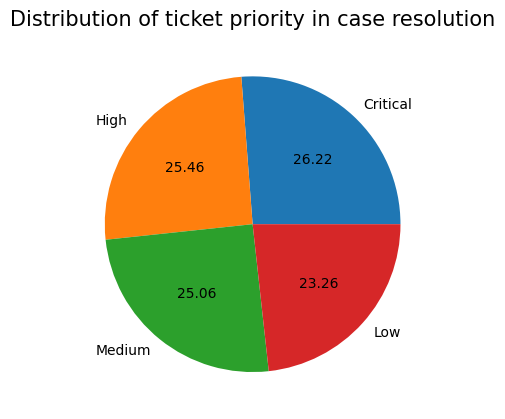

In [33]:
chart_reprio = df_resolution['Ticket Priority'].value_counts()
plt.pie(chart_reprio, labels = chart_reprio.index, autopct = '%.2f')
plt.title('Distribution of ticket priority in case resolution', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** For a clearly look, I will grade low for the score 1 and 2, medium for 3 and high for 4 and 5.

In [34]:
rating = []
for i in df_resolution['Customer Satisfaction Rating']:
    if i<=2:
        rating.append('Low')
    elif i==3:
        rating.append('Medium')
    else:
        rating.append('High')
df_resolution['Type of rating'] = rating

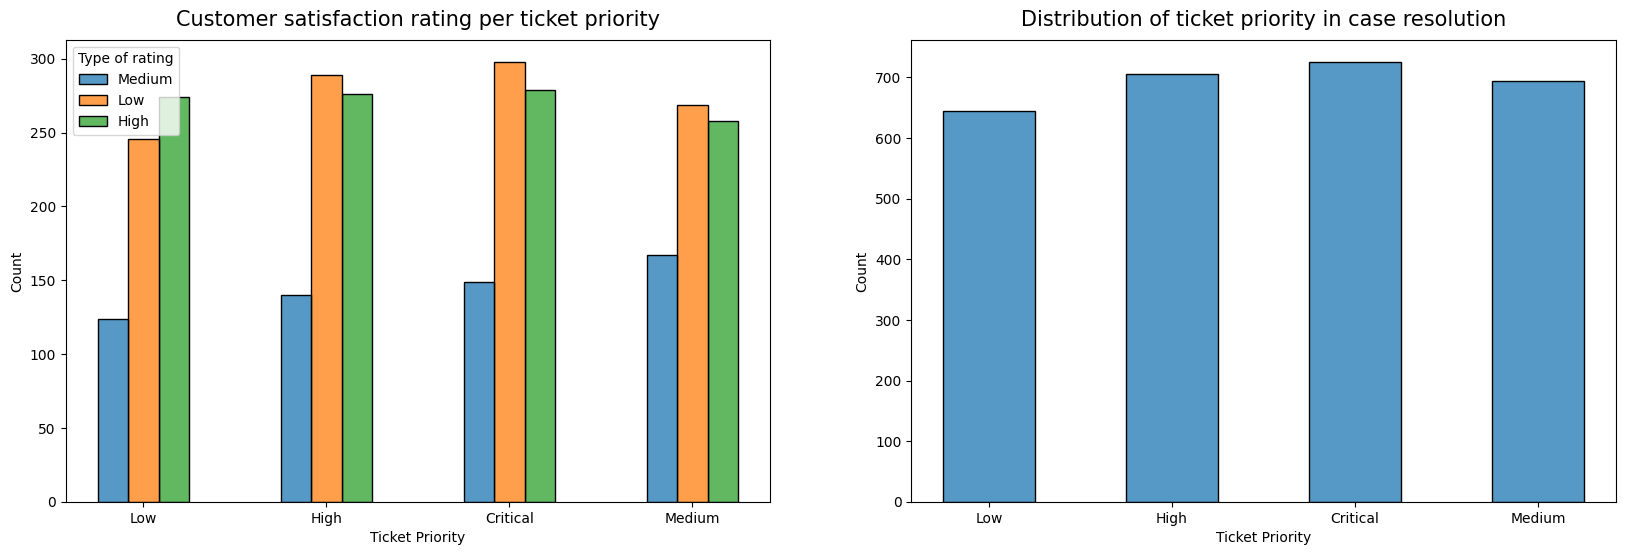

In [35]:
#Customer satisfaction rating and ticket priority
fig, axes = plt.subplots(1,2, figsize = (20,6))
sns.histplot(df_resolution, x = 'Ticket Priority', hue = 'Type of rating' ,multiple = 'dodge', shrink = 0.5, ax = axes[0])
sns.histplot(df_resolution['Ticket Priority'], shrink = 0.5, ax = axes[1])
axes[0].set_title('Customer satisfaction rating per ticket priority', loc = 'center', pad = 10, size = 15)
axes[1].set_title('Distribution of ticket priority in case resolution', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:** As we see above, the distribution of rating scores and priority are quite similar. However:
- Critical tickets are graded highest priority but also a priority have most number of customer gave low rating score
- This priority also reach the highest in number of customers judged high score but the number of cases given low rating were more than high rating.
- The second rank in both low and high rating were high priority.

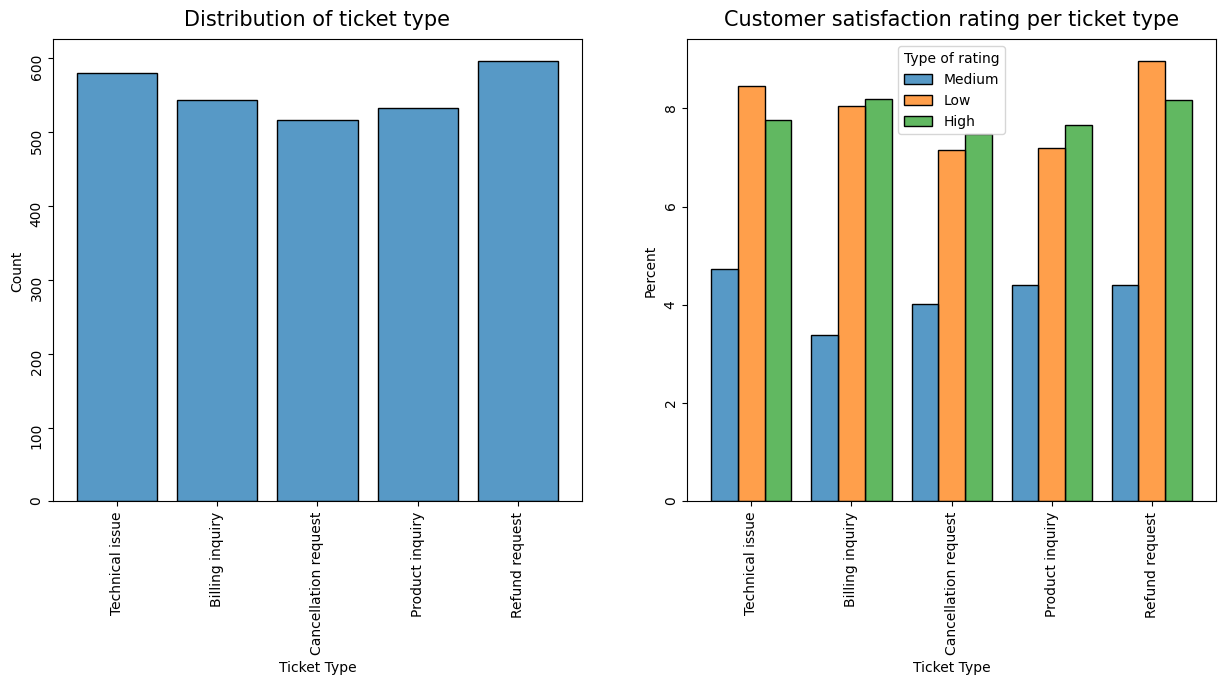

In [36]:
#Customer satisfaction rating and ticket type
fig, axes = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df_resolution['Ticket Type'], shrink = 0.8, ax = axes[0])
sns.histplot(hue = df_resolution['Type of rating'], x = df_resolution['Ticket Type'], multiple = 'dodge', shrink = 0.8, stat = 'percent', ax = axes[1])
axes[0].tick_params(labelrotation = 90)
axes[1].tick_params(labelrotation = 90)
axes[0].set_title('Distribution of ticket type', loc = 'center', pad = 10, size = 15)
axes[1].set_title('Customer satisfaction rating per ticket type', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:**
- Refund request and technical issue are two problems had more low rating score than high rating score.
- Refund request was the type had the most ticket resolved but also the type got the most low rating score.
- The remain types worked well and kept the amount of high rating score more than low rating score.

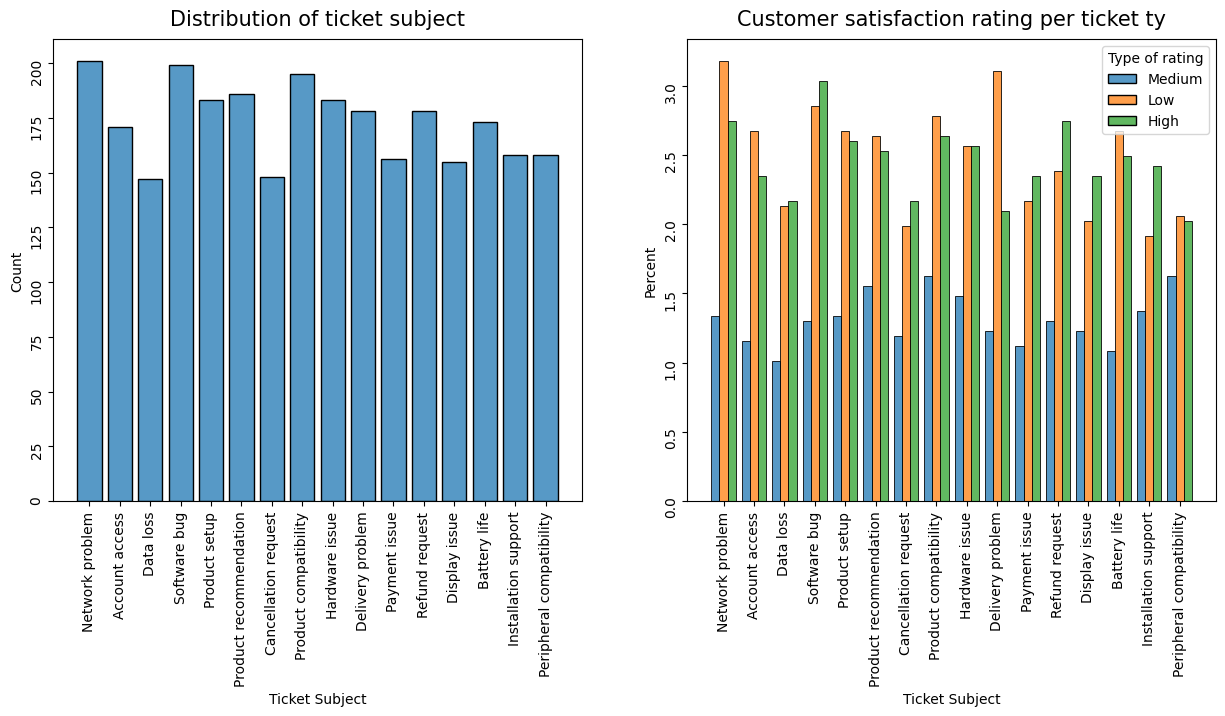

In [37]:
#Customer satisfaction rating and ticket subject
fig, axes = plt.subplots(1,2, figsize = (15,6))
sns.histplot(df_resolution['Ticket Subject'], shrink = 0.8, ax = axes[0])
sns.histplot(hue = df_resolution['Type of rating'], x = df_resolution['Ticket Subject'], multiple = 'dodge', shrink = 0.8, stat = 'percent', ax = axes[1])
axes[0].tick_params(labelrotation = 90)
axes[1].tick_params(labelrotation = 90)
axes[0].set_title('Distribution of ticket subject', loc = 'center', pad = 10, size = 15)
axes[1].set_title('Customer satisfaction rating per ticket ty', loc = 'center', pad = 10, size = 15)
plt.show()

**💬 Comment:**
- The top problems customer met after using product are network problem, software bug and product compatibility.
- In top three, only software bug had amount of high rating more than low. Network problem was the subject have the most number ticket was sent and the most low rating score as well.
- Software bug was also the subject get the most high rating score.
- By the way, delivery problem subject should be get more attention in quality support service because the amount of low rating score in this subject ticket nearly doubled then the high rating score.

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">
Conclusion:

- The priority ticket may reflect the severity of problem customer met and that's why they need supporters.
- All four types of priority didn't have too much different in the number of customers rating per type of score.
- However, when using this dataset for my project, I don't know whether the priority were assigned by customers who sent the ticket or staff in support ticket department who read the description of customers.
- Nevermind, support ticket department should have more attention in quality service in complex cases and have a right attitude when suporting all problem of purchased customer.
- Beside, support ticket department should pay more attention to the quality service in some ticket subjects were rated bad by customer such as delivery problem or network problem.

<a id="2.5"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>5. Sentiment Analysis</b></div>

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">
    This part will focus on text in Ticket Description columns and get some interesting insights from them. I will judge the text severity of ticket description base on ticket prority, ticket subject and whether it were resolved.

<a id="2.5.1"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>a. Create new dataframe</b></div>

In [38]:
df_sentiment = df_ticket[['Ticket Description', 'Resolution', 'Ticket Priority', 'Ticket Subject', 'Resolution_bin']]
df_sentiment.head()

,Ticket Description,Resolution,Ticket Priority,Ticket Subject,Resolution_bin
0,I'm having an issue with the {product_purchase...,None,Critical,Product setup,No
1,I'm having an issue with the {product_purchase...,None,Critical,Peripheral compatibility,No
2,I'm facing a problem with my {product_purchase...,Case maybe show recently my computer follow.,Low,Network problem,Yes
3,I'm having an issue with the {product_purchase...,Try capital clearly never color toward story.,Low,Account access,Yes
4,I'm having an issue with the {product_purchase...,West decision evidence bit.,Low,Data loss,Yes


<a id="2.5.2"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>b. Cleaning text</b></div>

**💬 Comment:** Next step is delete all the character don't have any effect on processing.

In [39]:
#Cleaning text
def clean_text(text):
    text = str(text).lower()
    text = re.sub('[({})?/$#|=]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[.]', ' ', text)
    text = re.sub('[->]', ' ', text)
    text = re.sub('[:]', ' ', text)
    text = re.sub('[_]', ' ', text)
    text = re.sub('[,]', ' ', text)
    text = re.sub('[-]', ' ', text)
    text = re.sub('[\']', ' ', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [40]:
#Apply texts were cleaned in 'Ticket Description' column
df_sentiment['Ticket Description'] = df_sentiment['Ticket Description'].apply(lambda x:clean_text(x))

In [41]:
df_sentiment['Resolution'] = df_sentiment['Resolution'].apply(lambda x:clean_text(x))

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">
Stop words are words that are so common and they are basically ignored by typical tokenizers. This project will use stopwords in nltk library for removing them in description ticket.

In [42]:
#Add useless words to stopwords
new_stopwords = ['i\'m', 'i\'ve', 'would', 'could', '-d', '-i\'m', '[--]:', 'not', 'mm', 'ca', 'cs', 'hi']
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

In [43]:
#Write a funtion for removing stopwords
def remove_stopword(x):
    return [y for y in x if y not in stpwrd]

<a id="2.5.3"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>c. Common words in description ticket</b></div>

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">
I will create a new column only contain words splited in 'Description Ticket' and 'Resolution' column and plot top 20 common words into chart.

In [44]:
#Creat new column for Description Ticket
df_sentiment['temp1'] = df_sentiment['Ticket Description'].apply(lambda x:str(x).split())
df_sentiment['temp1'] = df_sentiment['temp1'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in df_sentiment['temp1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

<Axes: xlabel='count', ylabel='Common_words'>

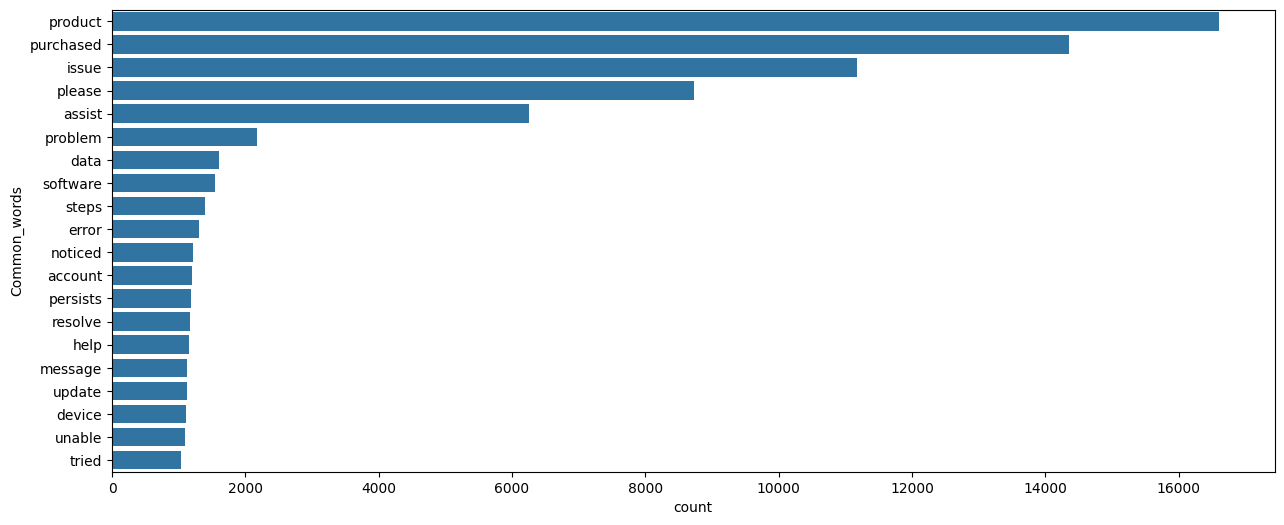

In [45]:
#Plot into chart
plt.figure(figsize = (15,6))
sns.barplot(temp, y = 'Common_words', x = 'count')

In [46]:
df_sentiment_resolution = df_sentiment[df_sentiment['Resolution_bin'] == 'Yes']

In [47]:
df_sentiment_resolution['temp2'] = df_sentiment_resolution['Resolution'].apply(lambda x:str(x).split())
df_sentiment_resolution['temp2'] = df_sentiment_resolution['temp2'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in df_sentiment_resolution['temp2'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']

<Axes: xlabel='count', ylabel='Common_words'>

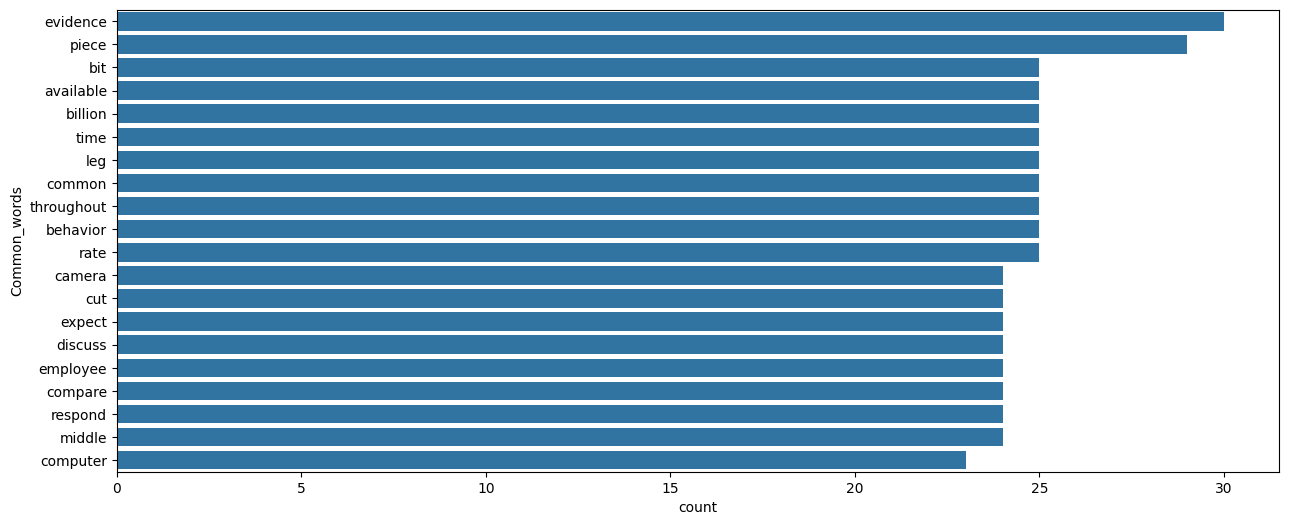

In [48]:
plt.figure(figsize = (15,6))
sns.barplot(temp, y = 'Common_words', x = 'count')

<a id="2.5.4"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>d. Common words in description ticket per subject ticket</b></div>

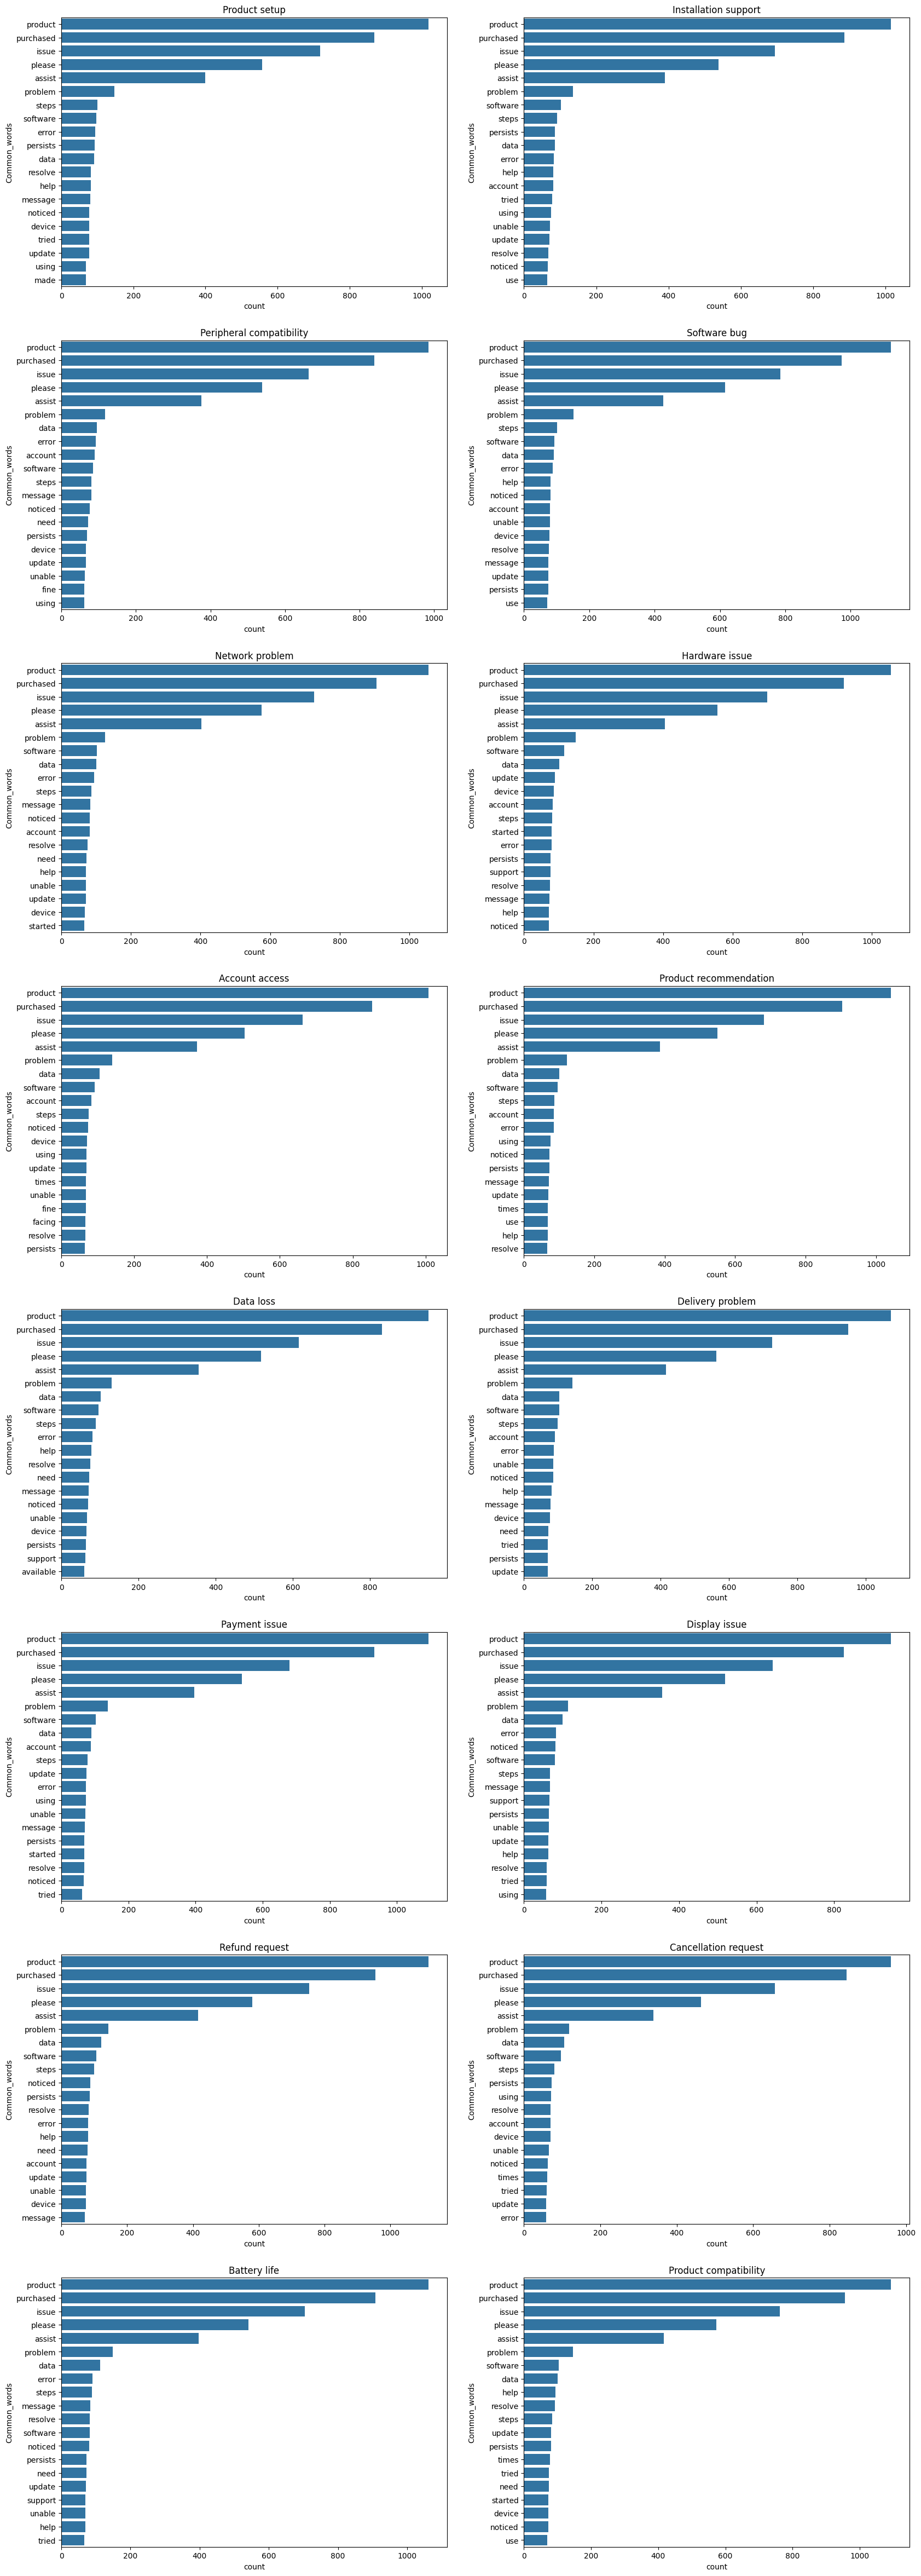

In [49]:
fig, axes = plt.subplots(8,2, figsize = (20,60))
for i, col in enumerate(df_sentiment['Ticket Subject'].unique()):
    idx = i%8
    idr = i//8
    table = df_sentiment[df_sentiment['Ticket Subject'] == col]
    table['temp'] = table['Ticket Description'].apply(lambda x:str(x).split())
    table['temp'] = table['temp'].apply(lambda x:remove_stopword(x))
    top = Counter([item for sublist in table['temp'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    sns.barplot(temp, y = 'Common_words', x = 'count', ax = axes[idx, idr])
    axes[idx, idr].set_title(col)
plt.show()

<a id="2.5.4"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>d. Unique words in description</b></div>

In [50]:
raw_text = [word for word_list in df_sentiment['temp1'] for word in word_list]

In [51]:
#Unique words funtion
def unique_word(sentiment, numwords, raw_words):
    allother = []
    for item in df_sentiment[df_sentiment.Resolution_bin != sentiment]['temp1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specific = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df_sentiment[df_sentiment.Resolution_bin == sentiment]['temp1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specific)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [52]:
resolve = unique_word('Yes', 20, raw_text)
resolve.style.background_gradient(cmap='Greens')

,words,count
0,consumers,4
1,font,4
2,gist,4
3,batteries,4
4,bottles,4
5,knowing,4
6,therefore,4
7,sentencethe,4
8,youtu,4
9,blockchain,3


In [53]:
none = unique_word('No', 20, raw_text)
none.style.background_gradient(cmap='Blues')

,words,count
0,property,12
1,perfect,9
2,gaming,9
3,decided,8
4,wants,8
5,platform,8
6,]game,8
7,suggest,7
8,isp,7
9,willing,7


<a id="2.5.5"></a>
# <div style='padding:15px;display:fill;color:black;font-size:15px;font-family:Verdana;text-align:left;background-color:#fffff;overflow:hidden'><b>d. Unique words in resolution</b></div>

In [54]:
df_sentiment_resolution

,Ticket Description,Resolution,Ticket Priority,Ticket Subject,Resolution_bin,temp1,temp2
2,i m facing a problem with my product purchased...,case maybe show recently my computer follow,Low,Network problem,Yes,"[facing, problem, product, purchased, product,...","[case, maybe, show, recently, computer, follow]"
3,i m having an issue with the product purchased...,try capital clearly never color toward story,Low,Account access,Yes,"[issue, product, purchased, please, assist, pr...","[try, capital, clearly, never, color, toward, ..."
4,i m having an issue with the product purchased...,west decision evidence bit,Low,Data loss,Yes,"[issue, product, purchased, please, assist, no...","[west, decision, evidence, bit]"
10,i m having an issue with the product purchased...,measure tonight surface feel forward,High,Data loss,Yes,"[issue, product, purchased, please, assist, pr...","[measure, tonight, surface, feel, forward]"
11,i m having an issue with the product purchased...,measure there house management pick knowledge ...,High,Software bug,Yes,"[issue, product, purchased, please, assist, po...","[measure, house, management, pick, knowledge, ..."
...,...,...,...,...,...,...,...
8452,i m having an issue with the product purchased...,interesting show must successful,Critical,Display issue,Yes,"[issue, product, purchased, please, assist, –,...","[interesting, show, must, successful]"
8453,the product purchased is unable to establish a...,skill expect admit and,High,Peripheral compatibility,Yes,"[product, purchased, unable, establish, stable...","[skill, expect, admit]"
8455,i ve recently set up my product purchased but...,say position key appear behavior,High,Refund request,Yes,"[recently, set, product, purchased, fails, con...","[say, position, key, appear, behavior]"
8466,i m having an issue with the product purchased...,eight account century nature kitchen,High,Account access,Yes,"[issue, product, purchased, please, assist, us...","[eight, account, century, nature, kitchen]"


In [55]:
def unique_word(sentiment, numwords, raw_words):
    allother = []
    for item in df_sentiment_resolution[df_sentiment_resolution.Resolution_bin != sentiment]['temp2']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specific = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df_sentiment_resolution[df_sentiment_resolution.Resolution_bin == sentiment]['temp2']:
        for word in item:
            mycounter[word] += 1
    keep = list(specific)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

In [56]:
resolve = unique_word('Yes', 20, raw_text)
resolve.style.background_gradient(cmap='Greens')

,words,count
0,piece,29
1,bit,25
2,available,25
3,time,25
4,common,25
5,behavior,25
6,rate,25
7,camera,24
8,cut,24
9,expect,24


<a id="2.6"></a>
# <div style="padding:15px;color:#A1C2F1;margin:0;font-size:25px;font-family:Verdana;text-align:left;display:fill;border-radius:2px;background-color:#fffff;overflow:hidden"><b>6. WordCloud</b></div>

In [57]:
#Funtion
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=30, figure_size=(20,10), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)



    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()


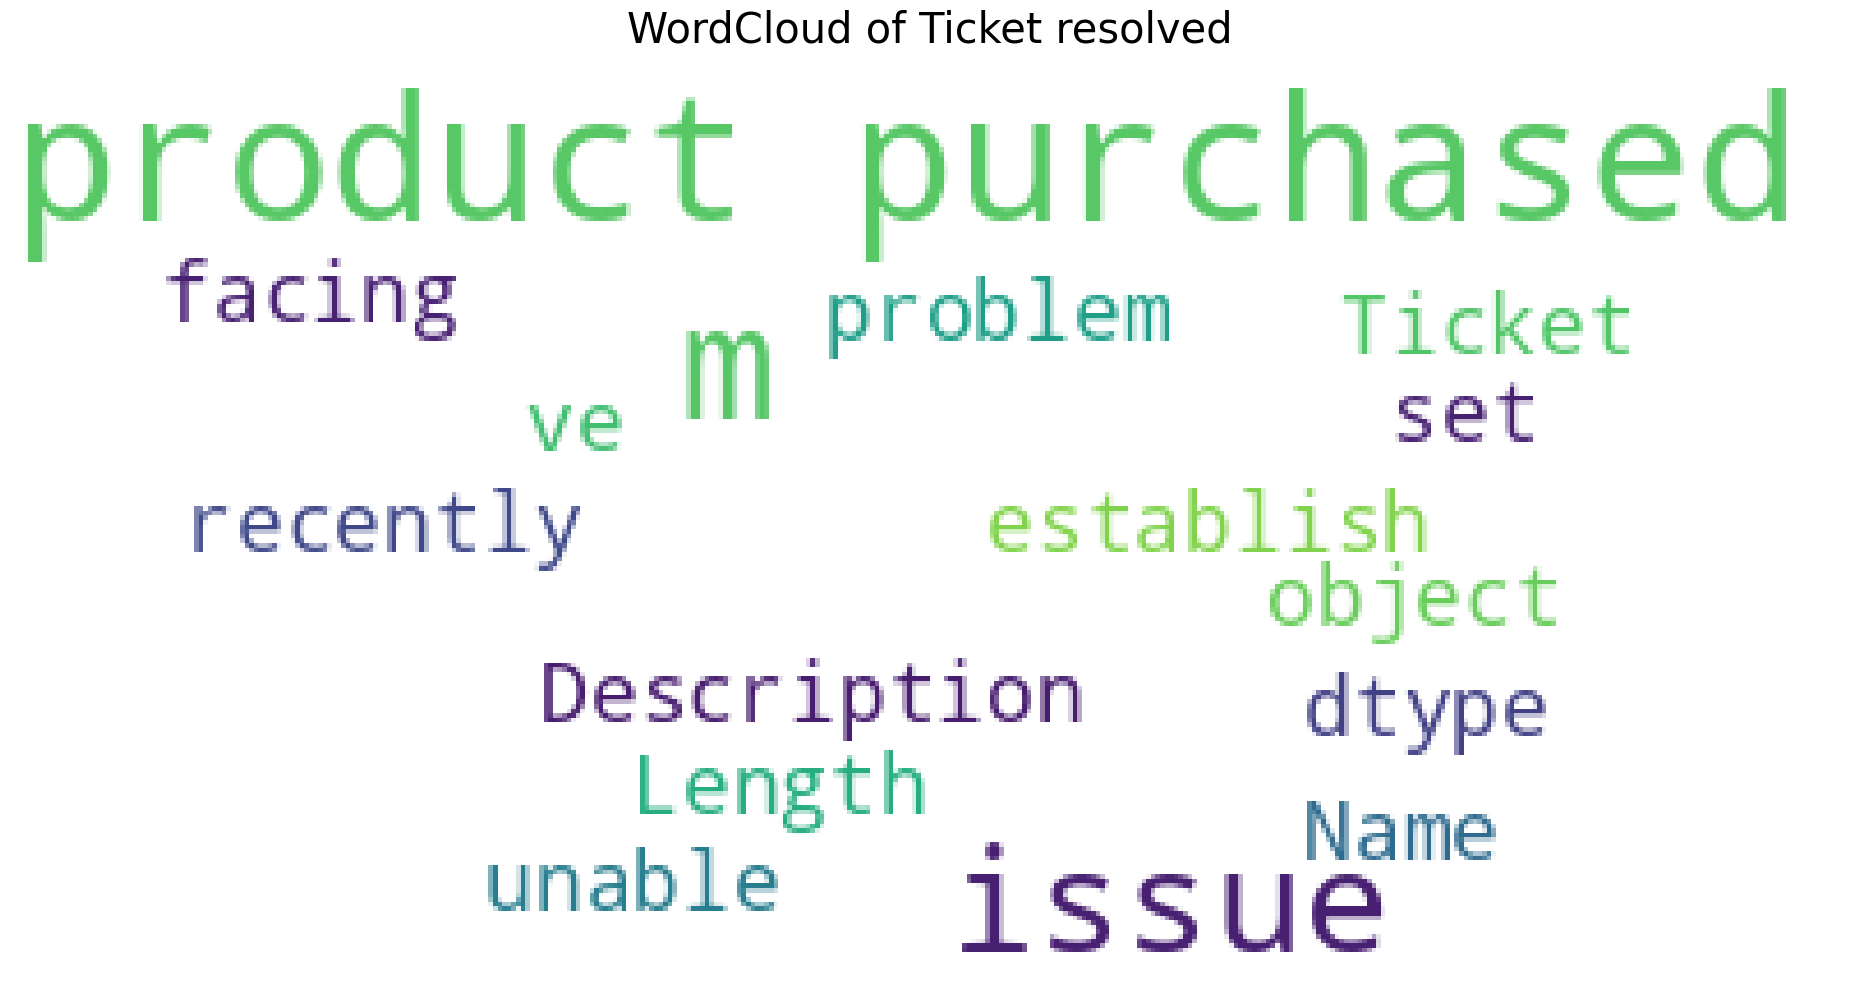

In [58]:
plot_wordcloud(df_sentiment[df_sentiment['Resolution_bin'] == 'Yes']['Ticket Description'],mask=None,color='white',max_font_size=50,title_size=30,title="WordCloud of Ticket resolved")

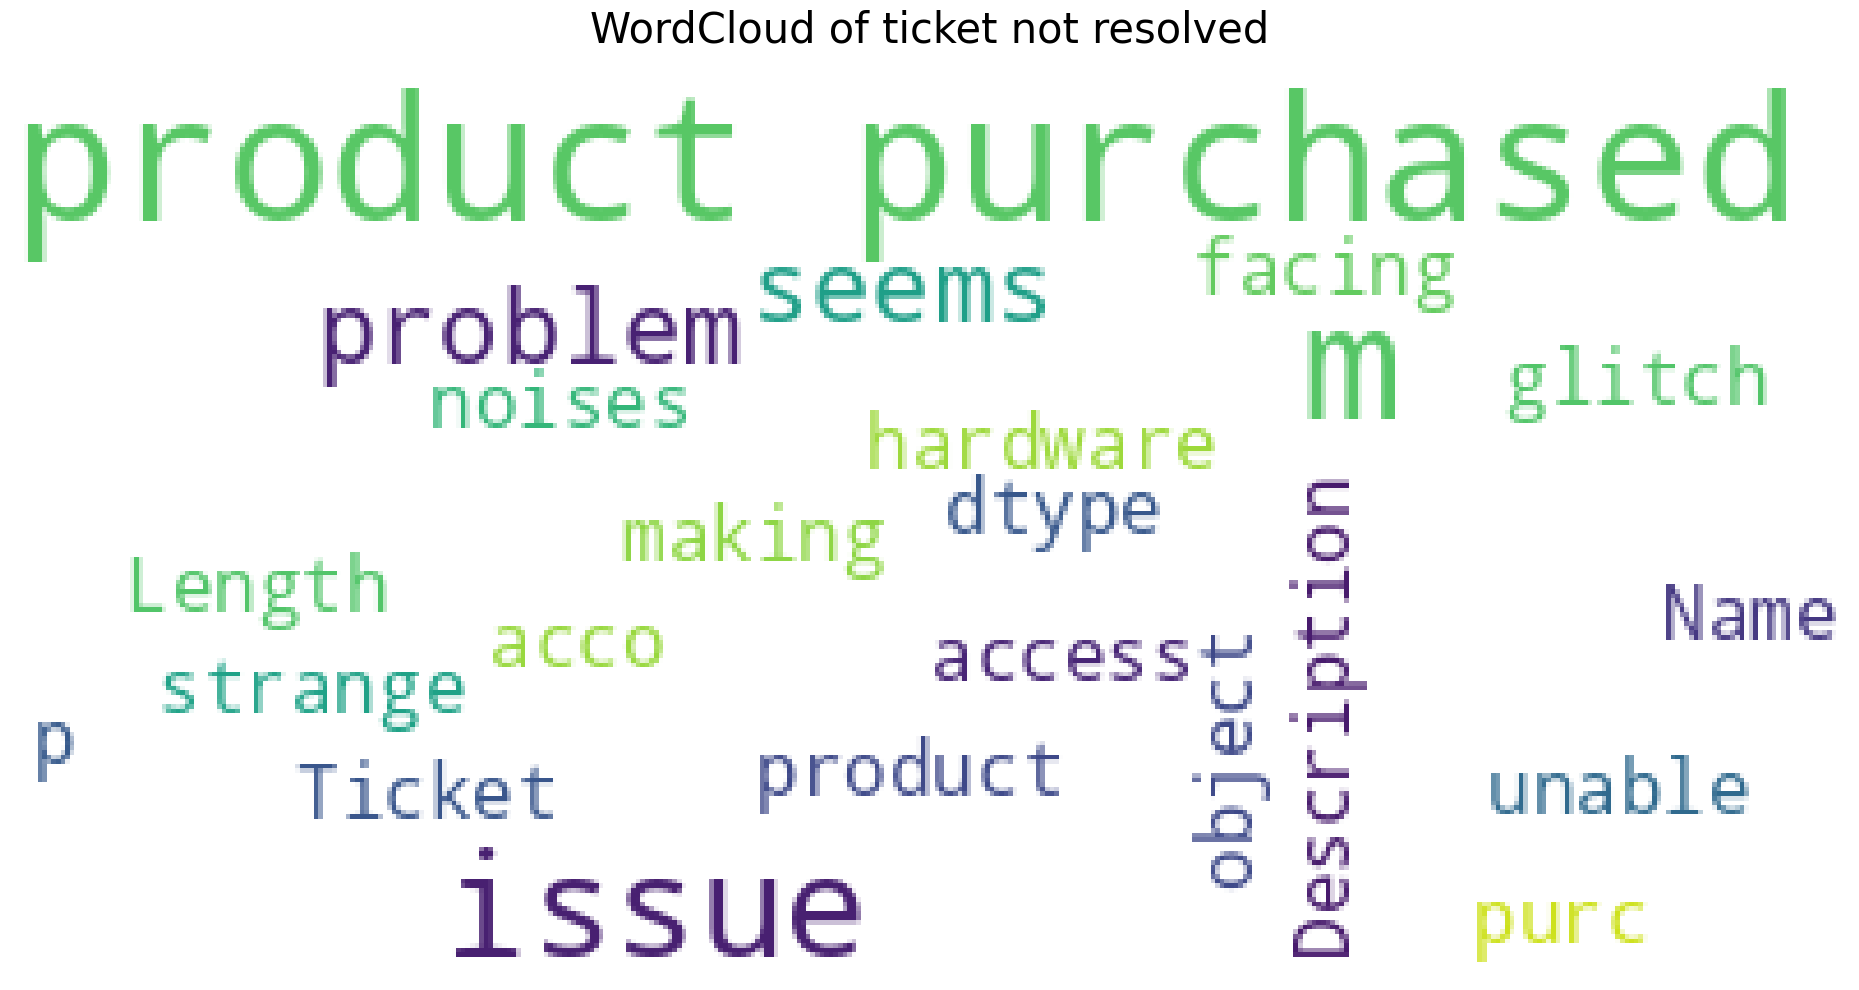

In [59]:
plot_wordcloud(df_sentiment[df_sentiment['Resolution_bin'] == 'No']['Ticket Description'],mask=None,color='white',max_font_size=50,title_size=30,title="WordCloud of ticket not resolved")

<a id="3"></a>
# <div style="padding:15px;color:blue;margin:0;font-size:35px;font-family:Verdana;text-align:left;display:fill;border-radius:5px;background-color:orange;overflow:hidden"><b>III. MODELING</b></div>

In [60]:
#Caculate the interval between time to resolution and first response time
df_resolution['Interval'] = df_resolution['Time to Resolution'] - df_resolution['First Response Time']

In [61]:
#Convert them into hours and float type
df_resolution['Interval'] = round(df_resolution['Interval'].dt.total_seconds()/(3600.0),2)

In [62]:
df_resolution['Interval'].describe()

count    2769.000000
mean       -0.057703
std         9.564164
min       -23.230000
25%        -6.930000
50%         0.170000
75%         6.480000
max        23.470000
Name: Interval, dtype: float64

<div style="border-radius:10px;border:#0C6A86 solid;padding: 10px;background-color:#C1ECE4;font-size:110%;text-align:left">In this case, values about interval show both positive and negative number so there are two case in resovling and responsing to customer:
    
- Reponse to customers first when receiving their purchased product problem description then resolve them
- Resolve the problem first then respones to customers when receiving their purchased product problem description

<Axes: xlabel='Interval', ylabel='Customer Satisfaction Rating'>

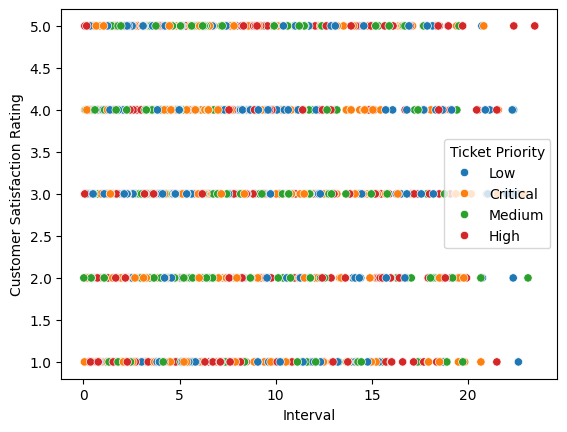

In [63]:
sns.scatterplot(df_resolution[df_resolution['Interval'] > 0], x= 'Interval', y = 'Customer Satisfaction Rating', hue = 'Ticket Priority')

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

In [65]:
label = df_resolution[['Customer Gender', 'Ticket Type', 'Ticket Subject', 'Ticket Priority', 'Ticket Channel', 'Type of Customer', 'Type of rating']]
encoder = LabelEncoder()
for col in label:
    value = np.unique(df_resolution[col])
    df_resolution[col] = encoder.fit_transform(df_resolution[col])
    encode_value = encoder.transform(value)

In [66]:
df_resolution.head()

,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,...,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Type of Customer,Response,Resolution_bin,Type of rating,Interval
2,Christopher Robbins,gonzalestracy@example.com,48,2,Dell XPS,2020-07-14,4,8,I'm facing a problem with my {product_purchase...,Closed,...,2,3,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,0,Yes,Yes,2,6.85
3,Christina Dillon,bradleyolson@example.org,27,0,Microsoft Office,2020-11-13,0,0,I'm having an issue with the {product_purchase...,Closed,...,2,3,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,2,Yes,Yes,2,-5.53
4,Alexander Carroll,bradleymark@example.com,67,0,Autodesk AutoCAD,2020-02-04,0,3,I'm having an issue with the {product_purchase...,Closed,...,2,1,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,1,Yes,Yes,1,19.68
10,Joseph Moreno,mbrown@example.org,48,1,Nintendo Switch,2021-01-19,1,3,I'm having an issue with the {product_purchase...,Closed,...,1,2,2023-06-01 17:46:49,2023-05-31 23:51:49,1.0,0,Yes,Yes,1,-17.92
11,Brandon Arnold,davisjohn@example.net,51,1,Microsoft Xbox Controller,2021-10-24,2,15,I'm having an issue with the {product_purchase...,Closed,...,1,0,2023-06-01 12:05:51,2023-06-01 09:27:51,1.0,0,Yes,Yes,1,-2.63


In [67]:
y = df_resolution['Type of rating']
X = df_resolution.drop(columns = ['Customer Name', 'Customer Email', 'Customer Age', 'Product Purchased', 'Date of Purchase',
                                 'Ticket Description', 'Ticket Status', 'First Response Time', 'Time to Resolution', 'Response',
                                 'Resolution_bin' ,'Resolution'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [68]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')

In [69]:
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [70]:
y_pred = model.predict(X_test)

In [71]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       227
           2       1.00      1.00      1.00       115

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



<Axes: >

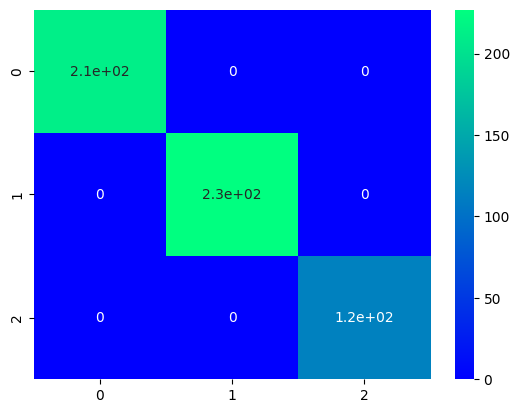

In [72]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, cmap = 'winter', annot = True)